

The first step is to learn about the input data


### Metadata

The data were collected after the 1992 eruption of Cerro Negro volcano (Nicaragua) to learn more about eruption source parameters (ESPs). The data file consists of 21 columns these are:

1. Sample ID - this simply a number corresponding to a specific sample location. In some cases more than one sample is collected at a specific location, so the sample ID is repeated in the data set. One location has one sample ID.

2. Layer - The 1992 eruption occurred in 2 phases and these two phases deposited 2 layers which can be distinguished in some stratigraphic sections. The layers are "a" and "b". Layer a is stratigraphically below layer b. The first phase of the eruption deposited layer a, then there was a pause, followed by a second eruption that deposited layer b. In some sections the layers are not distinguished. For example, far from the volcano it is difficult to know if a layer is a or b. These layers are designated layer "m", for mixed. But they are probably not actually mixed, they are just not distinguished. Think of M as a combined measurement. To model the combined measurements, add the a + b rows into one row.

3. easting - this is the UTM easting location of the Sample ID location (m)

4. northing - this is the UTM northing of the Sample ID location (m)

5. total(kg/m2) - this is the mass loading in kg/m2 dry deposit observed at each Sample ID location and for each layer (a,b, of m). Mass loading can be converted to thickness since the deposit density is 1000 kg/m3

6-21. This is the mass loading by grainsize, from phi class equal to or coarser than $-4 \phi$ (coarse particles) to fine particles $>3 \phi$, seived in $1/2 \phi$ increments. If one adds the phi size mass loadings together, one should get the total (column 5). This can be used as a check on the data quality.

So the column headers are specific parameters, the rows are analyses associated with each sample location. The index goes from zero to the total number of observations. Sample ID is not used as an index because often two samples are collected at each location.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
import pandas as pd

# ===== Config (edit as needed) =====
FILENAME = "1924 Tephra Physical Volcanology Data.csv"  # your local file in current dir
OUTFILE  = "kilauea_1924.csv"                           # cleaned output name
SHOW_CONTEXT = True                                     # set False to skip context scan
CONTEXT_CHARS = 16                                      # chars before/after undecodable

# ===== Locate file =====
csv_path = Path(FILENAME)
print("Looking for:", csv_path.resolve())
if not csv_path.exists():
    raise FileNotFoundError(f"Place the CSV here or update FILENAME: {csv_path}")

# ===== Read with safe decoding =====
df = pd.read_csv(csv_path, encoding="utf-8", encoding_errors="replace", engine="python")

# Normalize column names
df.columns = [c.replace("\uFFFD", "(mu)").replace("μ", "(mu)") for c in df.columns]

# Replacement pass + report
replacement_report = []
for col in df.select_dtypes(include="object").columns:
    s = df[col].astype(str)
    n_bad = int(s.str.contains("\uFFFD", na=False).sum())
    n_mu  = int(s.str.contains("μ", na=False).sum())
    if n_bad or n_mu:
        replacement_report.append((col, n_bad, n_mu))
    s = s.str.replace("\uFFFD", "(mu)", regex=False).str.replace("μ", "(mu)", regex=False)
    df[col] = s

if replacement_report:
    print("\n[Encoding Notice] Replacements applied:")
    for col, n_bad, n_mu in replacement_report:
        print(f"  - {col}: {n_bad} undecodable -> (mu), {n_mu} 'μ' -> (mu)")
else:
    print("\n[Encoding Notice] No undecodable chars or 'μ' found.")

# Optional: print context around undecodables in the ORIGINAL read (before replacements)
if SHOW_CONTEXT:
    print("\n[Context] Snippets around undecodable (�) in original read:")
    total = 0
    df_raw = pd.read_csv(csv_path, encoding="utf-8", encoding_errors="replace", engine="python")
    for r in range(len(df_raw)):
        for col in df_raw.columns:
            val = df_raw.iloc[r][col]
            if pd.isna(val):
                continue
            s = str(val)
            start = 0
            while True:
                pos = s.find("\uFFFD", start)
                if pos == -1:
                    break
                left = max(0, pos - CONTEXT_CHARS)
                right = min(len(s), pos + 1 + CONTEXT_CHARS)
                ctx = s[left:right]
                print(f"  row={r}, col={col!r}, pos={pos}, ctx=...{ctx}...")
                total += 1
                start = pos + 1
    if total == 0:
        print("  (none)")

# ===== Save cleaned CSV =====
out_path = Path(OUTFILE)
df.to_csv(out_path, index=False)
print(f"\nCleaned CSV saved to: {out_path.resolve()}")

Looking for: /Users/jimyhc/Desktop/research/DSI/root/data_std/1924 Tephra Physical Volcanology Data.csv

[Encoding Notice] Replacements applied:
  - Grain Size Distribution of Each Sample (Fractions): 2 undecodable -> (mu), 0 'μ' -> (mu)
  - Statistical Distribution Data: 1 undecodable -> (mu), 0 'μ' -> (mu)

[Context] Snippets around undecodable (�) in original read:
  row=0, col='Grain Size Distribution of Each Sample (Fractions)', pos=18, ctx=...wer Size Limit (�m)...
  row=1, col='Grain Size Distribution of Each Sample (Fractions)', pos=18, ctx=...per Size Limit (�m)...
  row=1, col='Statistical Distribution Data', pos=5, ctx=...D50 (�m)...

Cleaned CSV saved to: /Users/jimyhc/Desktop/research/DSI/root/data_std/kilauea_1924.csv


In [3]:
hi = pd.read_csv(out_path, skiprows=2)
hi.head()

,Sample Number,Easting,Northing,Distance from Approximate Center of 1924 Vent (m),Eruption,Thickness (cm),Distinctive Field Features,Unnamed: 7,Mean Grain Size,Mode,...,Kurtosis (?),Mean (?),Sorting (?).1,Skewness (?).1,Kurtosis (?).1,Unnamed: 66,Mean SPHT3,Mean b/l3,Mean Compct3,Mean RDNS_C3
0,K21-DD45C-2018,259607.0,2146565.0,1037.0,2018,4.0,NaN,NaN,Extremely Fine Ash,Unimodal,...,3.73,4.51,1.60,-0.23,0.80,NaN,0.78,0.69,0.83,0.39
1,K21-DD45C-1,259607.0,2146565.0,1037.0,1924,1.0,NaN,NaN,Medium Ash,Polymodal,...,2.70,1.63,2.61,-0.12,0.73,NaN,0.77,0.68,0.82,0.34
2,K21-DD45C-2,259607.0,2146565.0,1037.0,1924,5.0,NaN,NaN,Coarse Ash,Polymodal,...,1.95,0.86,2.89,0.11,0.56,NaN,0.80,0.71,0.83,0.36
3,K21-DD45C-3,259607.0,2146565.0,1037.0,1924,1.5,NaN,NaN,Coarse Ash,Trimodal,...,3.33,0.73,2.19,0.24,0.71,NaN,0.81,0.71,0.83,0.38
4,K21-DD45C-4,259607.0,2146565.0,1037.0,1924,3.5,NaN,NaN,Medium Ash,Bimodal,...,3.00,1.11,2.55,0.30,0.64,NaN,0.81,0.71,0.83,0.36


In [4]:
cn = pd.read_csv('./cerro_negro.dat')
cn.head()

,sample,layer,easting,northing,total(kg/m2),<=-4phi,<=-3.5phi,<=-3phi,<=-2.5phi,<=-2phi,...,<=-1phi,<=-0.5phi,<=0phi,<=0.5phi,<=1phi,<=1.5phi,<=2phi,<=2.5phi,<=3phi,>3phi
0,1,a,526774,1381087,324.22,1.21,3.45,12.69,49.02,39.56,...,64.53,39.58,23.64,13.24,1.62,0.31,0.07,0.02,0.00,0.00
1,1,b,526774,1381087,184.96,0.00,0.00,0.85,5.25,11.39,...,33.84,44.73,31.50,22.20,10.47,3.77,0.75,0.10,0.02,0.00
2,2,a,526028,1380972,207.68,0.00,1.50,6.57,11.78,24.43,...,47.14,43.06,21.30,5.35,1.68,0.45,0.27,0.05,0.00,0.00
3,2,b,526028,1380972,48.62,0.00,0.00,0.25,1.18,2.64,...,13.78,9.62,6.42,3.39,1.65,1.51,0.85,0.26,0.13,0.14
4,3,a,525477,1380291,311.62,0.00,0.81,1.29,7.34,13.96,...,45.60,67.55,64.89,56.34,20.82,4.52,0.40,0.08,0.00,0.00


In [5]:
# Simple, straightforward build per your instructions.
# - No flexible matching, exact column names only.
# - Uses your prior filenames and patterns.
# - Standardizes both datasets to the SAME column format:
#     easting, northing, mass_value, mass_unit
# - Aggregates duplicates by (easting, northing, mass_unit) with summed mass_value.
# - Saves 4 CSVs in the current directory: hi_std.csv, hi_std_agg.csv, cn_std.csv, cn_std_agg.csv
#
# Assumptions (based on your notes):
#   HI file  : 'kilauea_1924.csv' with a 2-line header offset -> use skiprows=2
#              Columns used: 'Easting', 'Northing', 'Total Dry Weight (g)', 'Eruption' (filter == 1924)
#   CN file  : 'cerro_negro.dat' (CSV)
#              Columns used: 'easting', 'northing', 'total(kg/m2)'
#
# If any required column is missing, this cell will raise a clear KeyError.

import pandas as pd
from pathlib import Path

# ---------- Paths ----------
HI_IN  = Path("kilauea_1924.csv")
CN_IN  = Path("cerro_negro.dat")

HI_STD = Path("hi_std.csv")
HI_AGG = Path("hi_std_agg.csv")
CN_STD = Path("cn_std.csv")
CN_AGG = Path("cn_std_agg.csv")

# ---------- HI: load, filter, select, standardize, aggregate ----------
if not HI_IN.exists():
    raise FileNotFoundError(f"HI file not found: {HI_IN.resolve()}")

hi_raw = pd.read_csv(HI_IN, skiprows=2, encoding="utf-8", encoding_errors="replace", engine="python")

required_hi_cols = ['Easting', 'Northing', 'Total Dry Weight (g)', 'Eruption']
missing = [c for c in required_hi_cols if c not in hi_raw.columns]
if missing:
    raise KeyError(f"HI missing columns: {missing}. Present columns: {list(hi_raw.columns)}")

# Filter Eruption == 1924
hi_filt = hi_raw[hi_raw['Eruption'].astype(str).str.strip() == "1924"].copy()

# Select and standardize columns
hi_std = hi_filt[['Easting', 'Northing', 'Total Dry Weight (g)']].copy()
hi_std.columns = ['easting', 'northing', 'mass_value']

# Enforce numeric types
hi_std['easting'] = pd.to_numeric(hi_std['easting'], errors='coerce')
hi_std['northing'] = pd.to_numeric(hi_std['northing'], errors='coerce')
hi_std['mass_value'] = pd.to_numeric(hi_std['mass_value'], errors='coerce')

hi_std['easting']  = hi_std['easting'].astype('int64')
hi_std['northing'] = hi_std['northing'].astype('int64')

hi_std = hi_std.dropna(subset=['easting', 'northing', 'mass_value'])

# Aggregate duplicates
hi_std_agg = hi_std.groupby(['easting', 'northing'], as_index=False)['mass_value'].sum()

# Save
hi_std.to_csv(HI_STD, index=False)
hi_std_agg.to_csv(HI_AGG, index=False)

# ---------- CN: load, select, standardize, aggregate ----------
if not CN_IN.exists():
    raise FileNotFoundError(f"CN file not found: {CN_IN.resolve()}")

cn_raw = pd.read_csv(CN_IN, encoding="utf-8", encoding_errors="replace", engine="python")

required_cn_cols = ['easting', 'northing', 'total(kg/m2)']
missing_cn = [c for c in required_cn_cols if c not in cn_raw.columns]
if missing_cn:
    raise KeyError(f"CN missing columns: {missing_cn}. Present columns: {list(cn_raw.columns)}")

cn_std = cn_raw[['easting', 'northing', 'total(kg/m2)']].copy()
cn_std.columns = ['easting', 'northing', 'mass_value']

# Enforce numeric types
cn_std['easting'] = pd.to_numeric(cn_std['easting'], errors='coerce')
cn_std['northing'] = pd.to_numeric(cn_std['northing'], errors='coerce')
cn_std['mass_value'] = pd.to_numeric(cn_std['mass_value'], errors='coerce')

cn_std = cn_std.dropna(subset=['easting', 'northing', 'mass_value'])

# Aggregate duplicates
cn_std_agg = cn_std.groupby(['easting', 'northing'], as_index=False)['mass_value'].sum()

# Save
cn_std.to_csv(CN_STD, index=False)
cn_std_agg.to_csv(CN_AGG, index=False)

print(f"Saved:\n - {HI_STD.resolve()}\n - {HI_AGG.resolve()}\n - {CN_STD.resolve()}\n - {CN_AGG.resolve()}")


Saved:
 - /Users/jimyhc/Desktop/research/DSI/root/data_std/hi_std.csv
 - /Users/jimyhc/Desktop/research/DSI/root/data_std/hi_std_agg.csv
 - /Users/jimyhc/Desktop/research/DSI/root/data_std/cn_std.csv
 - /Users/jimyhc/Desktop/research/DSI/root/data_std/cn_std_agg.csv


In [6]:
hi_df = pd.read_csv(HI_AGG)
hi_df = pd.read_csv(HI_STD)
print("Kilauea 1924 Aggregated Data")
print(hi_df.head())
print()

cn_df = pd.read_csv(CN_AGG)
cn_df = pd.read_csv(CN_STD)
print("Cerro Negro Aggregated Data")
print(cn_df.head())

Kilauea 1924 Aggregated Data
   easting  northing  mass_value
0   259607   2146565       13.73
1   259607   2146565      141.25
2   259607   2146565      139.02
3   259607   2146565      139.10
4   259607   2146565       65.99

Cerro Negro Aggregated Data
   easting  northing  mass_value
0   526774   1381087      324.22
1   526774   1381087      184.96
2   526028   1380972      207.68
3   526028   1380972       48.62
4   525477   1380291      311.62


Kilauea 1924 Aggregated Mass Value Median: 176.215


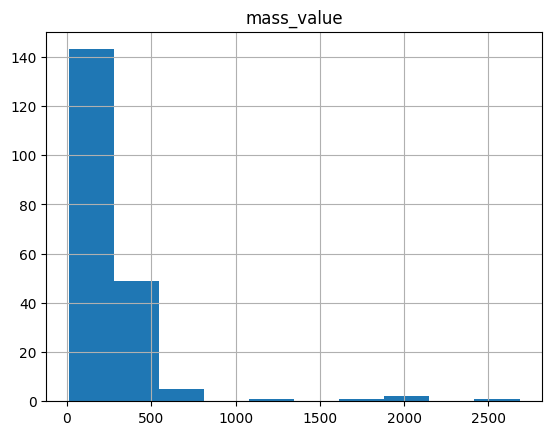

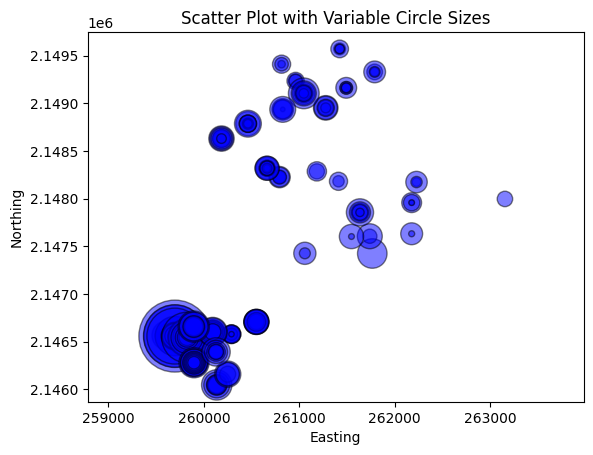

In [7]:
hi_median = hi_df["mass_value"].median()
print("Kilauea 1924 Aggregated Mass Value Median:", hi_median)
hi_df.hist("mass_value")
plt.show()

plt.scatter(hi_df['easting'], hi_df['northing'], s=hi_df['mass_value'], alpha=0.5, c='blue', edgecolors='black')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Scatter Plot with Variable Circle Sizes')
plt.axis('equal')
plt.show()

Kilauea 1924 Aggregated Mass Value Median: 211.695


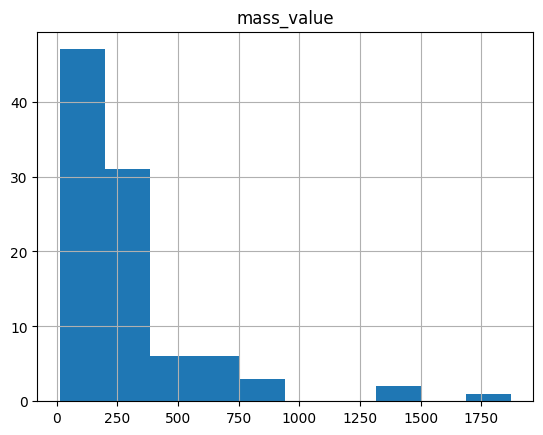

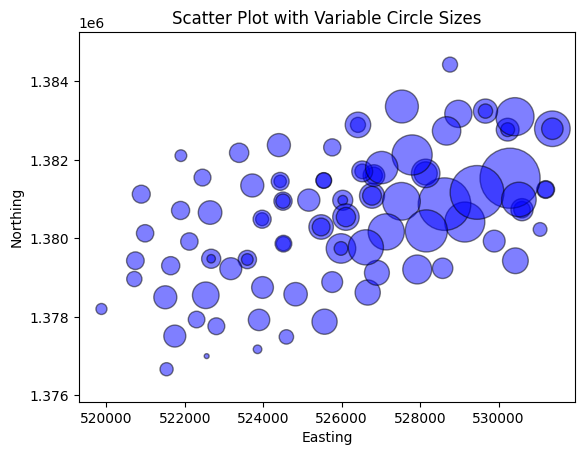

In [8]:
cn_median = cn_df["mass_value"].median()
print("Kilauea 1924 Aggregated Mass Value Median:", cn_median)
cn_df.hist("mass_value")
plt.show()

plt.scatter(cn_df['easting'], cn_df['northing'], s=cn_df['mass_value'], alpha=0.5, c='blue', edgecolors='black')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Scatter Plot with Variable Circle Sizes')
plt.axis('equal')
plt.show()